In [359]:
import torch
import torch.nn as nn
import numpy as np

import matplotlib.pyplot as plt

from tqdm import tqdm
import pdb

%matplotlib inline

In [360]:
device = "cpu" if torch.cuda.is_available() else "cuda:0" # если у тебя только CPU, то автоматически device = 'cpu'

In [361]:
device='cpu'

## Define target density

In [362]:
class Correlated_gaussian():
    '''
    This class defines correlated gaussian target (2d)
    '''
    def __init__(self, mu, covar):
        self.distr = torch.distributions.MultivariateNormal(loc=mu, covariance_matrix=covar)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, )) # аргументом должен быть iterable

In [363]:
## Option 1
mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
covar = torch.tensor([[1., 0.95], [0.95, 1.]], device=device, dtype=torch.float32)

# ## Option 2
# mu = torch.tensor([10., 3.], device=device, dtype=torch.float32) # тензор -- это объект данных, с которым работает pytorch
# covar = torch.tensor([[1., 0.], [0., 1.]], device=device, dtype=torch.float32)

In [364]:
target = Correlated_gaussian(mu, covar)

## Plot samples from the target

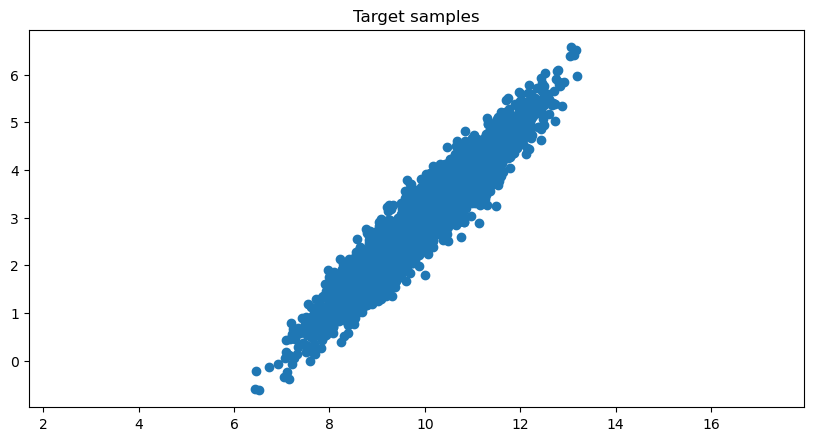

In [365]:
samples = target.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

## Variational inference

Мы выберем простое вариационное распределение: mean-field gaussian

Оно параметризуется двумя векторами -- вектор средних и вектор стандартных отклонений.

In [366]:
# torch.nn.Parameter -- это объект, который далее передается в оптимизатор, по параметрами после производится оптимизация
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

# обрати внимание, что это std_raw. Std должен быть >0, поэтому мы будем оптимизировать "сырой" вектор,
# который каждый раз будем подставлять в экспоненту

# то есть стартовые параметры, mu_param = 0, 0; std = exp(std_param_raw) = 1, 1
std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw],
                            lr=1e-2) # добавляем параметры в оптимайзер
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)


# стандартное нормальное распределение нужно нам для reparametrization trick (будет в статье про VAE)
std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [367]:
batch_size = 1000
num_batches = 10000

KL$(q_{\phi}(z)\|p(z)) = \int_z q_{\phi}(z)\log\frac{q_{\phi}(z)}{p(z)} dz = E_{q_{\phi}(z)}\log q_{\phi}(z) - E _{q_{\phi}(z)}\log p(z)$

Оценки мат.ожиданий из формулы выше будем брать методом Монте-Карло, то есть с помощью семплов

In [368]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2)) # это пригодится для reparametrization trick
    
    # Берем семплы из вариационного распределения:
    std = torch.exp(std_param_raw)
    z = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
                                                # случайные ноды в графе не распространяется
    ## посчитали KL по формуле выше
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target.get_logdensity(z).mean()
    
    # А дальше просто минимизируем KL:
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  2%|█▊                                                                          | 243/10000 [00:00<00:08, 1217.58it/s]

Current value of KL at batch number 0 is 271.0877685546875


 12%|█████████▏                                                                 | 1217/10000 [00:01<00:07, 1188.24it/s]

Current value of KL at batch number 1000 is 18.380416870117188


 22%|████████████████▎                                                          | 2180/10000 [00:01<00:06, 1122.75it/s]

Current value of KL at batch number 2000 is 9.834388732910156


 32%|███████████████████████▊                                                   | 3180/10000 [00:02<00:06, 1093.67it/s]

Current value of KL at batch number 3000 is 3.7610390186309814


 41%|███████████████████████████████                                            | 4136/10000 [00:03<00:04, 1178.78it/s]

Current value of KL at batch number 4000 is 1.5509295463562012


 52%|███████████████████████████████████████                                    | 5212/10000 [00:04<00:04, 1154.15it/s]

Current value of KL at batch number 5000 is 1.1893445253372192


 62%|██████████████████████████████████████████████▏                            | 6157/10000 [00:05<00:03, 1125.17it/s]

Current value of KL at batch number 6000 is 1.1930352449417114


 71%|█████████████████████████████████████████████████████▍                     | 7126/10000 [00:06<00:02, 1100.25it/s]

Current value of KL at batch number 7000 is 1.132285714149475


 82%|█████████████████████████████████████████████████████████████▍             | 8193/10000 [00:07<00:01, 1181.27it/s]

Current value of KL at batch number 8000 is 1.1326881647109985


 92%|████████████████████████████████████████████████████████████████████▋      | 9150/10000 [00:08<00:00, 1178.93it/s]

Current value of KL at batch number 9000 is 1.1813427209854126


100%|██████████████████████████████████████████████████████████████████████████| 10000/10000 [00:08<00:00, 1128.04it/s]


### Plot both: samples from variational family and target

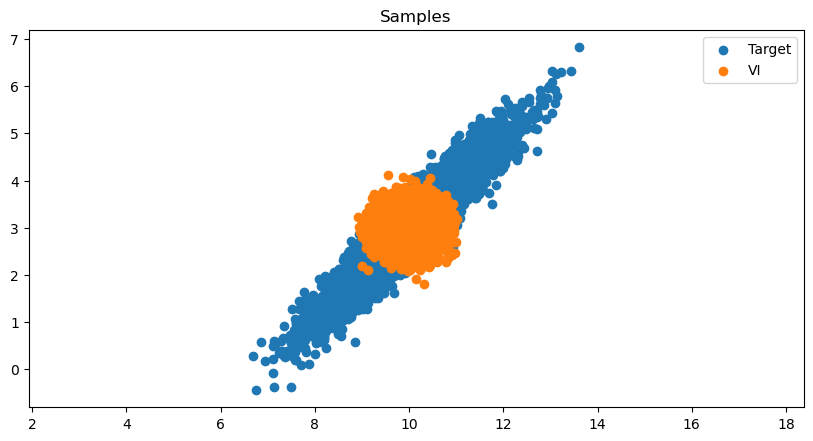

In [369]:
N = 5000

u = std_normal.sample((N, 2)) # это пригодится для reparametrization trick
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std # собственно, вот этот trick. Можешь пока думать об этом так, что градиент через
    
samples_target = target.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target[:, 0], samples_target[:, 1], label='Target')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();

## VI with GMM target

### Target

In [535]:
#### TODO: Добавь VI, таргетом для которого будет смесь двух гауссиан

class GMM():
    '''
    This class defines GMM (Gaussian Mixture Model) target (2d)
    '''
    def __init__(self, mus, covars):
        self.mus = mus
        self.covars = covars
        self.distr = torch.distributions.MixtureSameFamily(mus, covars)
        
    def get_logdensity(self, z): # оцениваем log_density в z
        return self.distr.log_prob(z)
    
    def get_samples(self, N): # N - сколько семплов нужно
        return self.distr.sample((N, ))

In [536]:
mix = torch.distributions.Categorical(torch.ones(2,))
comp = torch.distributions.Independent(torch.distributions.Normal(torch.randn(2,2), torch.rand(2,2)), 1)

In [537]:
target_gmm = GMM(mix, comp)

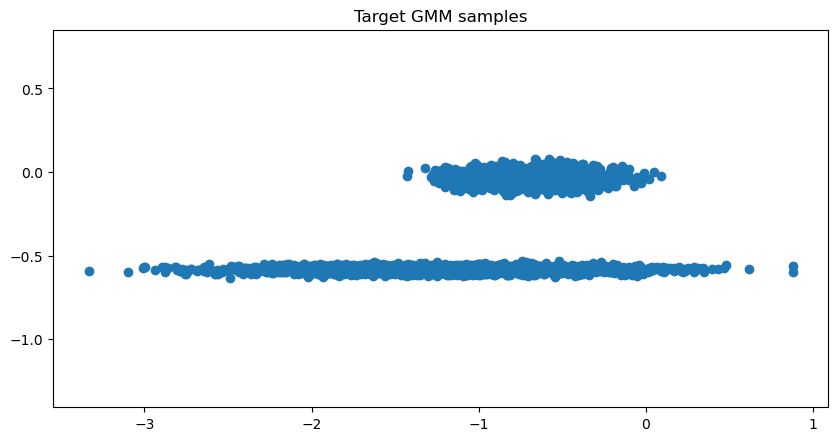

In [538]:
samples = target_gmm.get_samples(5000).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Target GMM samples')
plt.axis('equal')
plt.scatter(samples[:, 0], samples[:, 1]);

### VI model: unimodal Gaussian

In [539]:
mu_param = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32))

std_param_raw = nn.Parameter(torch.tensor([0., 0.], device=device, dtype=torch.float32)) 

optimizer = torch.optim.Adam(params=[mu_param, std_param_raw], lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))

In [540]:
for i in tqdm(range(num_batches)):
    u = std_normal.sample((batch_size, 2))
    
    std = torch.exp(std_param_raw)
    z = mu_param + u * std
    
    KL = -torch.sum(std_param_raw) + std_normal.log_prob(u).sum(1).mean() - target_gmm.get_logdensity(z).mean()
    
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")

  2%|█▎                                                                           | 178/10000 [00:00<00:11, 885.08it/s]

Current value of KL at batch number 0 is 492.1973876953125


 12%|████████▉                                                                   | 1175/10000 [00:01<00:09, 890.39it/s]

Current value of KL at batch number 1000 is 6.84508752822876


 22%|████████████████▌                                                           | 2174/10000 [00:02<00:08, 911.34it/s]

Current value of KL at batch number 2000 is 1.6528277397155762


 31%|███████████████████████▌                                                    | 3096/10000 [00:03<00:07, 914.68it/s]

Current value of KL at batch number 3000 is 0.8916136622428894


 42%|███████████████████████████████▊                                            | 4190/10000 [00:04<00:06, 906.35it/s]

Current value of KL at batch number 4000 is 0.7289983034133911


 51%|██████████████████████████████████████▋                                     | 5085/10000 [00:05<00:05, 846.83it/s]

Current value of KL at batch number 5000 is 0.697260856628418


 62%|██████████████████████████████████████████████▉                             | 6169/10000 [00:06<00:04, 915.32it/s]

Current value of KL at batch number 6000 is 0.6948519945144653


 72%|██████████████████████████████████████████████████████▋                     | 7188/10000 [00:08<00:03, 920.96it/s]

Current value of KL at batch number 7000 is 0.6948472261428833


 81%|█████████████████████████████████████████████████████████████▋              | 8109/10000 [00:09<00:02, 892.61it/s]

Current value of KL at batch number 8000 is 0.6965736150741577


 91%|█████████████████████████████████████████████████████████████████████▏      | 9103/10000 [00:10<00:00, 906.67it/s]

Current value of KL at batch number 9000 is 0.6930375099182129


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:11<00:00, 894.71it/s]


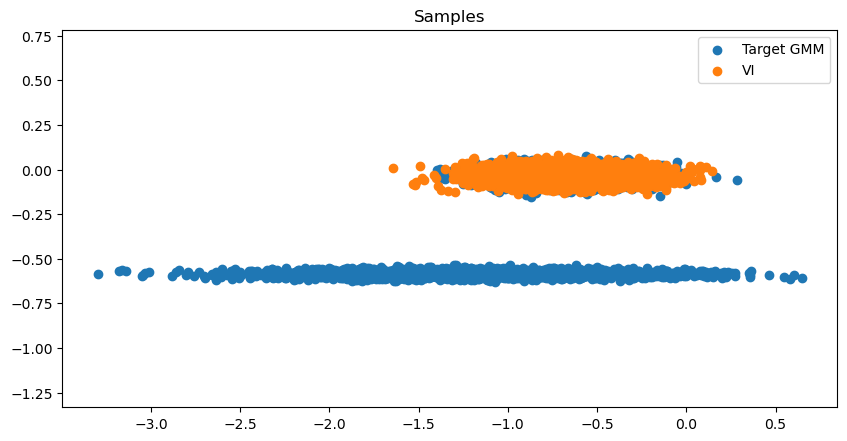

In [541]:
N = 5000

u = std_normal.sample((N, 2))
with torch.no_grad():
    std = torch.exp(std_param_raw)
    sample_varfamily = mu_param + u * std
    
samples_target_gmm = target_gmm.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target_gmm[:, 0], samples_target_gmm[:, 1], label='Target GMM')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI')
plt.axis('equal')
plt.legend();

## Approximating a mixture of Gaussians

In [720]:
mus_param = nn.Parameter(torch.tensor([[0., 0.],[1., 1.]], device=device, dtype=torch.float32))

stds_param_raw = nn.Parameter(torch.tensor([[0., 0.],[0., 0.]], device=device, dtype=torch.float32))

pi_raw = nn.Parameter(torch.tensor(0., device=device, dtype=torch.float32))

optimizer = torch.optim.Adam(params=[mus_param, stds_param_raw, pi_raw], lr=1e-2)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=100, gamma=0.75)

std_normal = torch.distributions.Normal(loc=torch.tensor(0., device=device, dtype=torch.float32),
                                       scale=torch.tensor(1., device=device, dtype=torch.float32))
KL_values = []

#std_normal1 = torch.distributions.Normal(loc=mus_param[0], scale=std[0])
#std_normal2 = torch.distributions.Normal(loc=mus_param[1], scale=std[1])
#mix = torch.distributions.Categorical(pi)
#comp = torch.distributions.Independent(torch.distributions.Normal(torch.randn(2,2), torch.rand(2,2)), 1)
#std_normal_mix = torch.distributions.MixtureSameFamily(mix, comp)

In [721]:
for i in tqdm(range(num_batches)):
    pi = torch.sigmoid(pi_raw)
    dist = torch.distributions.Bernoulli(probs=pi)
    c = dist.sample((batch_size,1))
       
    std = torch.exp(stds_param_raw)
    std_normal1 = torch.distributions.Normal(loc=torch.sum(mus_param[0]), scale=torch.sum(std[0]))
    std_normal2 = torch.distributions.Normal(loc=torch.sum(mus_param[1]), scale=torch.sum(std[1]))
    
    #u = std_normal1.sample((batch_size, 2)) * c + std_normal2.sample((batch_size, 2)) * (1 - c)
    
    u = std_normal.sample((batch_size, 2))
    
    #z = mus_param[0] + u * std[0]
    z = mus_param[1]*c + mus_param[0]*(1-c) + u * (std[1]*c + std[0]*(1-c)) # сэмпл из одной из гауссиан в зависимости от pi
    
    g1 = torch.log(1-pi) + std_normal1.log_prob(u).sum(1).mean()# - torch.sum(std[1]).detach()
    g2 = torch.log(pi) + std_normal2.log_prob(u).sum(1).mean() #- torch.sum(std[0]).detach()
    log_q_components = torch.cat((g1[None], g2[None]), 0)
    
    KL = -torch.sum(stds_param_raw) + torch.logsumexp(log_q_components, 0)\
        * (torch.logsumexp(log_q_components, 0) + 1 - target_gmm.get_logdensity(z).mean()).detach()\
        - target_gmm.get_logdensity(z).mean()
    #KL = -torch.sum(stds_param_raw) + std_normal.log_prob(u).sum(1).mean() * ( std_normal.log_prob(u).sum(1).mean() + 1 - target_gmm.get_logdensity(z).mean() ).detach() - target_gmm.get_logdensity(z).mean()
   
    KL.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    if i % 1000 == 0:
        print(f"Current value of KL at batch number {i} is {KL.cpu().detach().numpy()}")
        KL_values.append([i, KL.cpu().detach().numpy().item()])

  0%|▎                                                                             | 36/10000 [00:00<00:27, 357.15it/s]

Current value of KL at batch number 0 is -2072.440185546875


 10%|███████▉                                                                    | 1045/10000 [00:02<00:23, 378.65it/s]

Current value of KL at batch number 1000 is 73.5674057006836


 21%|███████████████▋                                                            | 2058/10000 [00:05<00:20, 386.75it/s]

Current value of KL at batch number 2000 is 48.85273361206055


 31%|███████████████████████▍                                                    | 3076/10000 [00:08<00:17, 385.76it/s]

Current value of KL at batch number 3000 is 19.89737319946289


 40%|██████████████████████████████▌                                             | 4021/10000 [00:11<00:21, 277.07it/s]

Current value of KL at batch number 4000 is 15.38302230834961


 50%|██████████████████████████████████████▎                                     | 5040/10000 [00:14<00:15, 319.35it/s]

Current value of KL at batch number 5000 is 14.416342735290527


 60%|█████████████████████████████████████████████▉                              | 6039/10000 [00:17<00:12, 305.25it/s]

Current value of KL at batch number 6000 is 13.554348945617676


 70%|█████████████████████████████████████████████████████▌                      | 7041/10000 [00:20<00:08, 335.64it/s]

Current value of KL at batch number 7000 is 13.389742851257324


 80%|█████████████████████████████████████████████████████████████▏              | 8046/10000 [00:23<00:05, 339.17it/s]

Current value of KL at batch number 8000 is 12.986612319946289


 90%|████████████████████████████████████████████████████████████████████▊       | 9049/10000 [00:26<00:02, 324.03it/s]

Current value of KL at batch number 9000 is 14.108290672302246


100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 333.87it/s]


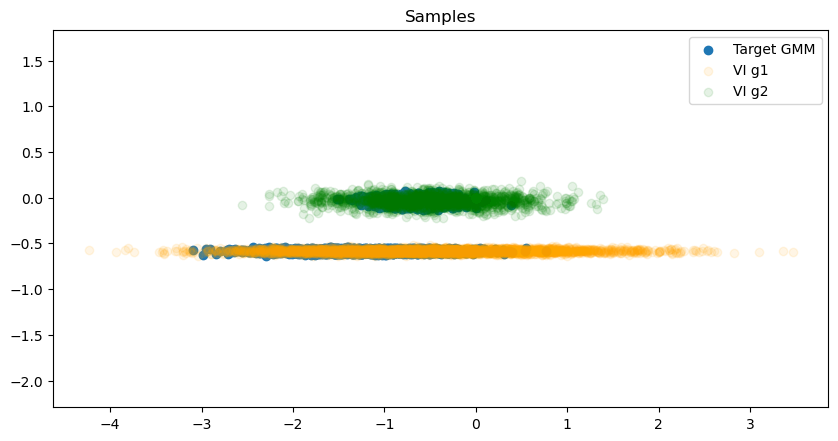

In [722]:
N = 5000

dist = torch.distributions.Bernoulli(probs=torch.sigmoid(pi_raw))
c =  dist.sample((N,1))
c = torch.cat((c,c), dim=1)
#c = torch.cat((c,c), dim=2) # to same dim as u
 
u = std_normal.sample((N,2))

with torch.no_grad():
    std = torch.exp(stds_param_raw)
    sample_varfamily = torch.cat(((mus_param[0] + u * std[0]) * (1-c), (mus_param[1] + u * std[1]) * c), 1)#(mus_param[0] + u * std[0]) * (1-c) + (mus_param[1] + u * std[1]) * c
    
samples_target_gmm = target_gmm.get_samples(N).cpu().numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.title('Samples')
plt.scatter(samples_target_gmm[:, 0], samples_target_gmm[:, 1], label='Target GMM')
plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI g1', color='orange', alpha=0.1)
plt.scatter(sample_varfamily[:, 2], sample_varfamily[:, 3], label='VI g2', color='green',alpha=0.1)
#plt.scatter(sample_varfamily[:, 0], sample_varfamily[:, 1], label='VI', alpha=0.1)
plt.axis('equal')
plt.legend();

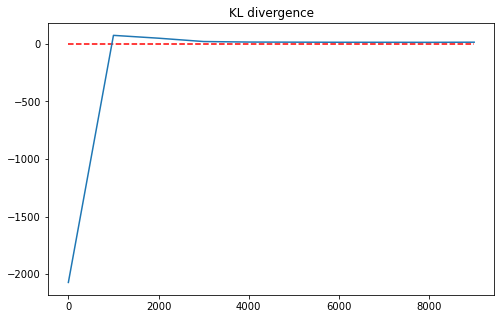

In [723]:
KL_values = np.array(KL_values)
plt.figure(figsize=(8, 5))
plt.title('KL divergence')
plt.plot(KL_values[:,0], KL_values[:,1])
plt.hlines(0, KL_values[:,0][0], KL_values[:,0][-1], color='r', linestyles='--')